In [1]:
import json

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
# ensure we run on the CPU
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

# Import netket library
import netket as nk

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt


In [10]:
import netket.nn as nknn
import flax.linen as nn

import jax.numpy as jnp

class FFNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=2*x.shape[-1], 
                     use_bias=True, 
                     param_dtype=np.complex128, 
                     kernel_init=nn.initializers.normal(stddev=0.01), 
                     bias_init=nn.initializers.normal(stddev=0.01)
                    )(x)
        x = nknn.log_cosh(x)
        x = jnp.sum(x, axis=-1)
        return x

In [4]:
data=json.load(open("data/n_14_0_test.log"))

In [5]:
iters = data['Energy']['iters']
energy=data['Energy']['Mean']['real']
sf=data['Structure Factor']['Mean']['real']

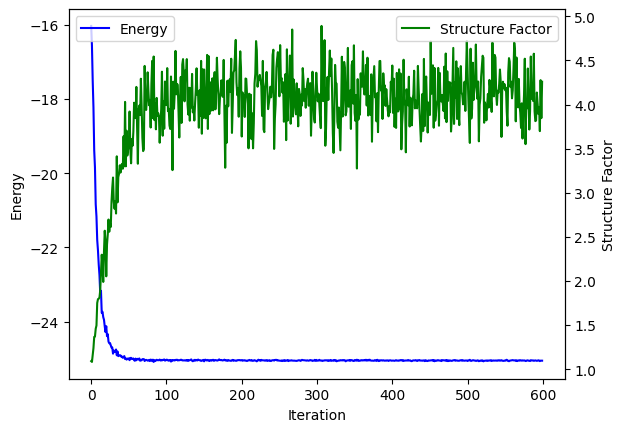

In [6]:
fig, ax1 = plt.subplots()
ax1.plot(iters, energy, color='blue', label='Energy')
ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration')
ax2 = ax1.twinx() 
ax2.plot(iters, np.array(sf), color='green', label='Structure Factor')
ax2.set_ylabel('Structure Factor')
ax1.legend(loc=2)
ax2.legend(loc=1)
plt.show()

In [7]:
print(r"Structure factor = {0:.3f}({1:.3f})".format(np.mean(sf[-50:]),
                                              np.std(np.array(sf[-50:]))/np.sqrt(50)))
print(r"Energy = {0:.3f}({1:.3f})".format(np.mean(energy[-50:]), np.std(energy[-50:])/(np.sqrt(50))))

Structure factor = 4.100(0.039)
Energy = -25.050(0.001)


In [11]:
J      = [1, 0]
L      = 14   
N_ITER = 600
MODEL  = FFNN()

In [12]:
run(J, L, N_ITER, MODEL)

Exact Ground-state Structure Factor: 4.124
Exact ground state energy = -25.054


In [8]:
def run(J, L, N_ITER, MODEL):
    
    model = MODEL
    
    edge_colors = []
    for i in range(L):
        edge_colors.append([i, (i+1)%L, 1])
        edge_colors.append([i, (i+2)%L, 2])

    g = nk.graph.Graph(edges=edge_colors)
    sigmaz = [[1, 0], [0, -1]]
    mszsz = (np.kron(sigmaz, sigmaz))
    exchange = np.asarray([[0, 0, 0, 0], [0, 0, 2, 0], [0, 2, 0, 0], [0, 0, 0, 0]])

    bond_operator = [
        (J[0] * mszsz).tolist(),
        (J[1] * mszsz).tolist(),
        (-J[0] * exchange).tolist(),  
        (J[1] * exchange).tolist(),
    ]

    bond_color = [1, 2, 1, 2]
    hi = nk.hilbert.Spin(s=0.5, total_sz=0.0, N=g.n_nodes)
    op = nk.operator.GraphOperator(hi, graph=g, bond_ops=bond_operator, bond_ops_colors=bond_color)
    sa = nk.sampler.MetropolisExchange(hilbert=hi, graph=g, d_max = 2)

    vs = nk.vqs.MCState(sa, model, n_samples=1008)

    opt = nk.optimizer.Sgd(learning_rate=0.01)

    sr = nk.optimizer.SR(diag_shift=0.01)

    gs = nk.VMC(hamiltonian=op, optimizer=opt, variational_state=vs, preconditioner=sr)
    
    sf = []
    sites = []
    structure_factor = nk.operator.LocalOperator(hi, dtype=complex)
    for i in range(0, L):
        for j in range(0, L):
            structure_factor += (nk.operator.spin.sigmaz(hi, i)*nk.operator.spin.sigmaz(hi, j))*((-1)**(i-j))/L
    
    E_gs, ket_gs = nk.exact.lanczos_ed(op, compute_eigenvectors=True)
    structure_factor_gs = (ket_gs.T.conj()@structure_factor.to_linear_operator()@ket_gs).real[0,0]
    print("Exact Ground-state Structure Factor: {0:.3f}".format(structure_factor_gs))
    print("Exact ground state energy = {0:.3f}".format(E_gs[0]))